In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import copy
import random
from matplotlib import pyplot as plt
import numpy as np
#From keras
import keras
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from keras import optimizers
from keras.utils import multi_gpu_model
from keras import backend as K
# From ssd_keras
from SSD_loss import SSDLoss
from importlib import reload
#import cv2
import pet_data
import detection_nets,classification_nets
import tensorflow as tf
from pet_detector_help import *
from matplotlib import pyplot as plt
from drawing import *

Using TensorFlow backend.


In [2]:
input_H = 224
input_W = 224
input_C = 3
input_shape = (input_H, input_W, input_C)
data_root = "/home/cai/dataset/pets/"
extras =  ['S', 512 ]
feature_map = [7,7,4,4,2,1]
aspect_ratios = [[2,3],[2,3],[2,3],[2,3],[2],[2]] 
mbox =  [2 + len(ar) * 2 for ar in aspect_ratios]  # number of boxes per feature map location
source_layers=["out_relu"]

In [3]:
annot = data_root + "annotations"

## Prepare classnames file and train test split

In [4]:
def generate_class_names(annot):
    list_names = open(annot + '/trainval.txt').readlines()
    class_names = []
    for name in list_names:
        name = name.lower()
        p = name.rfind('_')
        if not name[:p] in class_names:
            class_names.append(name[:p])
    print(class_names)
    file = open(os.path.join(annot,'class_names.txt'),'w')
    file.writelines([name + "\n" for name in class_names ])
generate_class_names(annot)
pet_data.split_annotations(data_root,'trainval.txt')

['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
before ignore: 3680
after ignore: 3671
[]


## Read classnames

In [5]:
#read_class_names(annot):
file = open(os.path.join(annot,'class_names.txt'))
lines = open(os.path.join(annot,'class_names.txt')).readlines()
class_names = [name[:-1] for name in lines]
class_names.insert(0,'background')
num_classes = len(class_names)
print(class_names)
print('classes num',num_classes)

['background', 'abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
classes num 38


## Load Dataset

In [6]:
reload(pet_data)
(x_train,y_train_no_process),(x_test,y_test_no_process) = pet_data.load_data(1,0.3,root=data_root,task = 'detection')
print("x_train shape",x_train.shape," y_train_no_process shape",y_train_no_process.shape)
print("x_test shape",x_test.shape," y_test_no_process shape",y_test_no_process.shape)

...............................done
x_train shape (2753, 224, 224, 3)  y_train_no_process shape (2753, 42)
x_test shape (275, 224, 224, 3)  y_test_no_process shape (275, 42)


## Generate prior boxes and process y

In [7]:
y_train = y_train_no_process.copy() #* [input_W,input_H,input_W,input_H]
y_test = y_test_no_process.copy() #* [input_W,input_H,input_W,input_H]

## Draw a sample of each class

In [ ]:
idx = []
class_pos = 0
for k,y in enumerate(y_train):
    if class_pos == num_classes:
        break
    if y[class_pos] == 1:
        idx.append(k)
        class_pos += 1
for i in  idx:
    x = x_train[i].copy()
    y = y_train_no_process[i].copy()
    h,w,_ = x_train[i].shape 
    #print(y_train_no_process[:,1])
    frame= (x * 255).astype('int32')
    draw_detection(frame,y,class_names,box_color=(0,255,0),font_scale =0.5,draw_label=True)
    plt.imshow(frame)
    plt.show()

In [ ]:
def label_transform(label,h,w):
    if label.ndim == 2:
        label[:,-4:] *= [w,h,w,h]
    elif label:
        label[-4:] *= [w,h,w,h]

In [8]:
#reload(pet_data)
(train_flow,val_flow) = pet_data.data_augment(x_train,y_train,8,task = 'detection_single',num_classes = num_classes)
image,labels = next(train_flow)
print('augmented data:label shape',labels.shape)
print('augmented data:image ',image.shape)
print(labels[0])

augmented data:label shape (8, 42)
augmented data:image  (8, 224, 224, 3)
[0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.28125    0.12053571 0.55803571 0.38392857]


### Set hyper params

In [24]:
reload(detection_nets)
base_name = "mobilenetv2"
version_name = "1.3"
source_name ="out_relu"
build_model = detection_nets.build_simple_detection_net
show_summary = False
#Train
phase = 'train' #training or testing
alpha = 0.8 # location loss ratio
epochs_per_stage = 10
stages = 2
epoch_decay = 0
batch_size = 8
verbose = True
data_augment = True
plot = True
#Environment
#clear_session = True
#Learning params
lr=5e-5
decay=1e-6
momentum=0.9
validation_split = 0.25
load_weights = True
save_weights = True
load_check_point = 7
save_path = 'saved_weights'
model_path = 'saved_models'
log_file = "log_detection"
log = True


### Build model with a backbone

In [25]:
#loss = SSDLoss().compute_loss
if phase!='test' and phase!='train':
    raise RuntimeError("Phase must be either train or test")
if epochs_per_stage < 1:
    raise RuntimeError("Epochs per stage must be greater than 1")
if stages < 1:
    raise RuntimeError("Stages must be greater than 1")
if phase == 'test' and load_weights != True:
    print("Warning: phase is testing and load weights is not True")
if not os.path.isdir(save_path):
    os.mkdir(save_path)
if not os.path.isdir(model_path):
    os.mkdir(model_path)
    
base_model = classification_nets.build_mobilenet_v2(input_shape=(input_H,input_W,input_C),output_num=num_classes)[1]
base_model.load_weights("saved_weights/mobilenet_v2_22.h5",by_name = True)
for layer in base_model.layers:
    layer.trainable = True
#base_model =  keras.applications.mobilenet_v2.MobileNetV2(input_shape=(input_H,input_W,input_C), alpha=1.0, 
#                                                          depth_multiplier=1, include_top=True, 
#                                                          weights='imagenet', input_tensor=None, pooling=None, classes=1000)
#freeze(base_model,50)
model_name,model = build_model(base_model,source_name,num_classes,version_name,base_name)
if show_summary:
    if log:
        json_string = model.to_json()
        model_file = open(model_path  + '/' + model_name + version_name,'w')
        model_file.write(json_string)
        model_file.close()
    model.summary()
print(model_name,'has been built ')

simple_detection_mobilenetv2_1.3 has been built 


## Define Loss Function

In [26]:
def Loss(y_true,y_pred):
    a = alpha
#    y_pred[:,-4:] * [input_W,input_H,input_W,input_H]
    pos_mask = 1 - y_true[:,0] 
    log_loss = -tf.reduce_sum(tf.reduce_sum(y_true[:,:-4] * tf.log(y_pred[:,:-4]), axis=-1))
#    log_loss = tf.reduce_sum(log_loss * pos_mask)
    mse_loss = tf.square(y_true[:,-4:] - y_pred[:,-4:])
    mse_loss = tf.reduce_sum(tf.boolean_mask(mse_loss,pos_mask))
    total_loss =  (1 + a ) * mse_loss + (1 - a ) * log_loss 
    return total_loss
model.compile(loss=Loss,optimizer=optimizers.SGD(lr=lr/10,decay=decay,momentum=momentum))

#### Check whether y train、y_test and output of model  have the same shape

In [27]:
print(model.output.get_shape(),y_train.shape)
assert((np.array(model.output.get_shape().as_list()[1:]) == np.array(y_train.shape[1:])).all())
assert((np.array(model.output.get_shape().as_list()[1:]) == np.array(y_test.shape[1:])).all())

(?, 42) (2753, 42)


## Train or Test

weights loaded from check point 7
model name simple_detection_mobilenetv2_1.3 
start fitting..  
stages: 2  epochs_per_stage: 10  plot_history: True  data_augmented: True 
trainset size: 2753  validation_split: 0.25 
learning rate: 5e-05  decay: 1e-06  momentum: 0.9 
load weight: False
Stage  1 / 2
Epoch num 10
Epoch 1/10
344/344 [==============================] - 58s 168ms/step - loss: 0.4599 - val_loss: 0.0560
Epoch 2/10
344/344 [==============================] - 39s 115ms/step - loss: 0.5285 - val_loss: 0.0556
Epoch 3/10
344/344 [==============================] - 41s 118ms/step - loss: 0.4693 - val_loss: 0.0548
Epoch 4/10
344/344 [==============================] - 38s 111ms/step - loss: 0.5166 - val_loss: 0.0547
Epoch 5/10
344/344 [==============================] - 41s 119ms/step - loss: 0.5137 - val_loss: 0.0549
Epoch 6/10
344/344 [==============================] - 45s 132ms/step - loss: 0.4930 - val_loss: 0.0548
Epoch 7/10
344/344 [==============================] - 42s 123ms/step 

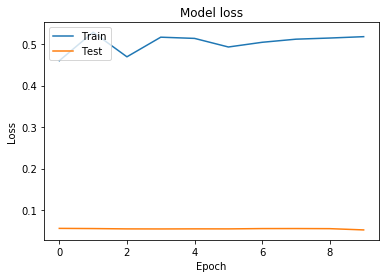

Stage  2 / 2
Epoch num 10
Epoch 1/10
344/344 [==============================] - 59s 172ms/step - loss: 0.4745 - val_loss: 0.0558
Epoch 2/10
344/344 [==============================] - 57s 167ms/step - loss: 0.4712 - val_loss: 0.0554
Epoch 3/10
344/344 [==============================] - 58s 168ms/step - loss: 0.5128 - val_loss: 0.0548
Epoch 4/10
344/344 [==============================] - 57s 166ms/step - loss: 0.4777 - val_loss: 0.0559
Epoch 5/10
344/344 [==============================] - 54s 158ms/step - loss: 0.4869 - val_loss: 0.0559
Epoch 6/10
344/344 [==============================] - 51s 148ms/step - loss: 0.4752 - val_loss: 0.0556
Epoch 7/10
344/344 [==============================] - 39s 113ms/step - loss: 0.4993 - val_loss: 0.0550
Epoch 8/10
344/344 [==============================] - 49s 141ms/step - loss: 0.4525 - val_loss: 0.0551
Epoch 9/10
344/344 [==============================] - 44s 129ms/step - loss: 0.4666 - val_loss: 0.0561
Epoch 10/10
344/344 [==========================

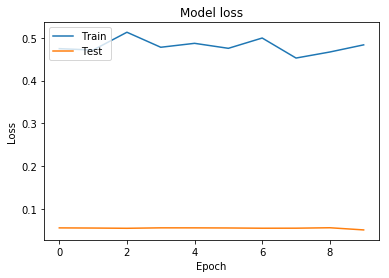

In [28]:
reload(pet_data)
try:
    if log:
        file = open(log_file,'a+')
    if load_weights:
        model.load_weights(save_path + '/' + model_name + '_' + str(load_check_point) + ".h5")
        print("weights loaded from check point",load_check_point)
        if phase == 'train':
            check_point = load_check_point + 1
            load_weights = False
    else:
        check_point = 1
    if phase == 'train':
        info =('model name' ,model_name , \
               '\nstart fitting.. ' , '\nstages:' , stages, ' epochs_per_stage:',epochs_per_stage, ' plot_history:' ,plot, ' data_augmented:', data_augment, \
               '\ntrainset size:', len(y_train), ' validation_split:',validation_split,\
               '\nlearning rate:' ,lr  ,' decay:' ,decay , ' momentum:' ,momentum ,  \
               '\nload weight:' ,load_weights)
        if verbose:
            print(*info)
        if log:
            print(*info,file=file)
        epochs = epochs_per_stage
        if data_augment:
            (train_flow,val_flow) = pet_data.data_augment(x_train,y_train,batch_size,validation_split,'detection_single',num_classes = num_classes)
            steps_per_epoch = len(x_train) // batch_size
            validation_steps = int(len(x_train) * validation_split) // batch_size
        for i in range(1,1+stages):
            if verbose:
                print("Stage ",i,"/",stages)
                print("Epoch num",epochs)
            if log:
                print("Stage ",i,"/",stages,file=file)
                print("Epoch num",epochs,file=file)
            if not data_augment:
                history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs, verbose = verbose, validation_split = validation_split)
            else:
                history = model.fit_generator(train_flow, steps_per_epoch = steps_per_epoch, validation_data = val_flow, validation_steps = validation_steps, epochs = epochs)
            
            path = save_path + '/' + model_name + '_' + str(check_point) + ".h5"
            if save_weights:
                if verbose:
                    print("save at",path)
                model.save_weights(path)
                check_point += 1 
            ac = evaluate(model,x_test,y_test)
            if verbose:
                print(ac)
            if log:
                print(ac,file=file)
            if plot:
                plot_history(history)
            epochs = epochs - epoch_decay // stages
    elif phase =='test':
        if verbose:
            print('start evaluating')
        loss = model.evaluate(x=x_test,y=y_test)
        ac = evaluate(model,x_test,y_test)
        if verbose:
            print('loss',round(loss,5))
            print('ac',ac)
        if log:
            print('loss',round(loss,5),file=file)
            print('ac',ac,file=file)
except Exception as ex:
    if  phase == 'train': check_point -= 1
    file.close()
    raise ex
   # model.save_weights(model_name + ".h5")

In [ ]:
\

In [17]:
result = model.evaluate(x=x_test,y=y_test)
print('loss',round(result,5))
print(evaluate(model,x_test,y_test))

275/275 [==============================] - 1s 2ms/step
loss 1.14323
{'loc accuracy': 0.9527, 'accuracy ': 0.88, 'class accuracy': 0.9164}


*Set hyper params and run all above from here*


#### Select a test image and do the prediction

In [ ]:
cats_idx = np.where(y_test[:,0] == 1)[0]
test_idx = [i*100 + j for i in range(3) for j in range(0,3,1)]
print('Test idx',test_idx,'total num',len(test_idx))
x = copy.deepcopy(x_test[test_idx])
y = copy.deepcopy(y_test[test_idx])
y_pred_no_process = model.predict(x)
y_pred = copy.deepcopy(y_pred_no_process.copy())

## Draw for single object detection

In [ ]:
image = (image*255).astype('int32')
y[:,-4:] *= [input_W,input_H,input_W,input_H]
y_pred[:,-4:] *= [input_W,input_H,input_W,input_H]
print(y_pred.shape)
for k,prediction  in enumerate(y_pred):
    #print(prediction)
    # Extract x from test set
    print("image: ",k)
    frame = (x[k] * 255).astype('int32') 
    truth = y[k]
    print(frame.shape)
    score = np.max(prediction[:-4])
    spec = np.argmax(prediction[:-4])
    print('loc pred',np.round(prediction[-4:],3))
    print('class pred',class_names[spec],'score',score)
    print('loc truth',np.round(truth[-4:],3))
    print('class truth',class_names[np.argmax(truth[:-4])]) 
    draw_detection(frame,prediction,class_names)
    draw_detection(frame,truth,class_names,box_color = (0,255,0))
    plt.imshow(frame)
    plt.show()

## Draw for multiobject detection

In [ ]:
for k,prediction  in enumerate(y_pred):
    #print(prediction)
    # Extract x from test set
    print("image: ",k)
    frame = (test_set[0][test_idx[k]]*255).astype('int32')
    for c,detections in enumerate(prediction):
        if len(detections) == 0:
            continue
        class_name = class_names[c]
        for detection in detections:
            score = detection[0]
            bbox = detection[1:] * input_H#corner
            print(class_name,score,bbox)
            bbox = bbox.astype('int32')
            draw_detection(frame,bbox,score,class_name,box_width = 3)
    plt.imshow(frame)
    plt.show()

In [ ]:
img_file = "data/dog3.jpg"
img = cv2.imread(img_file)
img = cv2.resize(img,(224,224))
print(img.shape)
x = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = np.array(x,dtype='float')
x = x / 255
y_pred = model.predict(np.expand_dims(x,0))[0]
y_pred[-4:] *= [224,224,224,224]
print(np.max(y_pred))
draw_detection(img,y_pred,class_names,box_width=2,font_scale=0.5)
plt.imshow(img)

Input Video Size: (960, 544)  Fps: 28.849740932642487  Frames: 145
[5.34491479e-01 5.49737783e-03 1.09775434e-03 1.63133757e-03
 8.09098259e-02 3.13178748e-01 1.93715133e-02 4.85945755e-04
 9.59070603e-05 1.54455111e-03 4.07394327e-05 2.13845610e-03
 1.62137707e-03 3.17590125e-03 7.47374608e-04 4.84434795e-03
 3.05995869e-04 6.10818330e-04 7.14675523e-04 1.24567116e-04
 6.46653207e-05 3.78968514e-04 4.99210972e-03 3.17960585e-05
 1.01882542e-04 7.73015781e-04 2.16233893e-05 4.80459799e-04
 1.15379255e-04 8.61778040e-04 4.12290770e-04 1.24834813e-04
 6.50159735e-03 7.14641530e-04 4.57196124e-03 9.72137204e-04
 7.70666869e-04 5.48147131e-03 3.80094849e+02 1.07065926e+02
 4.96884735e+02 2.94544495e+02]


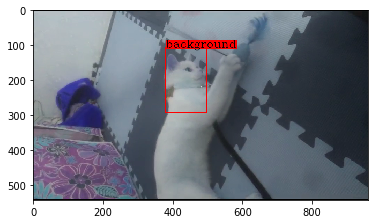

.[9.1568094e-01 2.0828014e-03 1.3230407e-03 1.6742779e-03 9.1580227e-03
 6.6349194e-03 1.2185721e-02 2.4671389e-03 7.8968279e-04 1.1502184e-03
 5.5552885e-04 1.9664983e-03 2.4131939e-03 4.1372771e-03 8.6695870e-04
 2.2294130e-03 1.1562112e-03 1.1874769e-03 8.4531103e-04 8.5713051e-04
 3.0359047e-04 2.2325641e-03 1.4062208e-03 5.4985925e-04 8.2755875e-04
 1.0563643e-03 1.6502482e-04 2.4516459e-03 7.4334716e-04 7.5525115e-04
 1.8610746e-03 1.0755358e-03 3.5641741e-03 1.4321535e-03 6.1988002e-03
 2.1575596e-03 1.8570615e-03 2.0003933e-03 3.4705246e+02 1.3759322e+02
 5.3542181e+02 3.6895224e+02]


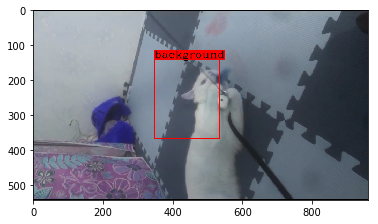

.done


In [32]:
video_file = "data/cat_video.mp4"
result_file = "res.avi"
cap= cv2.VideoCapture(video_file)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
frames = (int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Input Video Size:',size,' Fps:',fps,' Frames:',frames)
writer = cv2.VideoWriter(result_file,cv2.VideoWriter_fourcc(*'MJPG'), fps, size)
success,frame = cap.read()
count = 1
while success:
    x = cv2.resize(frame,dsize=(input_H,input_W),interpolation=cv2.INTER_CUBIC)
    x = x / 255
    y_pred = model.predict(np.expand_dims(x,0))[0]
    y_pred [-4:] *= [*size,*size]
    draw_detection(frame, y_pred,class_names,font_scale = 1)
    writer.write(frame)
    cv2.waitKey(1)
    count += 1
    if count%50==0:
        print(y_pred)
        plt.imshow(frame)
        plt.show()
        print('.',end='')
    success,frame = cap.read()
print('done')